# Weekly user sales prediction for CUPED

The notebook is to develop the sales forecasting model needed for CUPED.

In [9]:
import os
import json

import pandas as pd
import numpy as np
import catboost as cb
from itertools import product

from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

import sys
sys.path.append('..')

sns.set_theme("paper")

In [10]:
import warnings
warnings.filterwarnings('ignore')

from lib.utils import filter_outliers,  get_week_sales, get_data_set, load_json, save_json

PATH_DF_USERS = '../../data/df_users.csv'
PATH_DF_SALES = '../../data/df_sales.csv'

In [11]:
os.environ["MLFLOW_S3_ENDPOINT_URL"]="http://5.75.236.176:9000"
os.environ["MLFLOW_TRACKING_URI"]="http://5.75.236.176:5001"
os.environ["AWS_ACCESS_KEY_ID"]="IAM_ACCESS_KEY"
os.environ["AWS_SECRET_ACCESS_KEY"]="IAM_SECRET_KEY"

mlflow.set_tracking_uri("http://5.75.236.176:5001")
client = mlflow.tracking.MlflowClient()

experiment = client.get_experiment_by_name("cuped_sales_predicton")

In [12]:
users = pd.read_csv(PATH_DF_USERS)
sales = pd.read_csv(PATH_DF_SALES)

In [13]:
week_sales = get_week_sales(sales)

In [14]:
features = ['sales_2', 'sales_4', 'sales_1', 'sales_3', 
            'n_2', 'n_4', 
            'last_sale_1', 'last_sale_2', 'last_sale_3', 'last_sale_4',  
            'mean_sale_4',
            'age', 
            'week_type', 'first_day', 'week'
           ]

In [15]:
# T=6 validation 
# T=7 prod

def train_model(week_sales, T, vatidation=True, iterations=None, features=features):
    global experiment
    
    weeks_in = [T-2, T-1]

    for tau in [T-2, T-1, T]:
        week_sales = filter_outliers(week_sales, tau, interval=[50, 7500])

    all_users = users.user_id.unique()

    users_train = np.random.choice(all_users, 750000, False)
    ws_train = get_data_set(week_sales[week_sales.user_id.isin(users_train)],
                            users[users.user_id.isin(users_train)],
                            weeks_in=weeks_in)

    df = ws_train[ws_train['sales']>0]
    X_train = df.loc[:, features]
    y_train = df.loc[:, 'sales']

    users_test = np.random.choice(all_users, 450000, False)
    ws_test = get_data_set(week_sales[week_sales.user_id.isin(users_test)],
                            users[users.user_id.isin(users_test)],
                            weeks_in=[T])

    df = ws_test[ws_test['sales']>0]
    X_test = df.loc[:, features]
    y_test = df.loc[:, 'sales']

    train_dataset = cb.Pool(X_train, y_train, cat_features=['age'])
    test_dataset = cb.Pool(X_test, y_test, cat_features=['age'])

    params = {'loss_function': 'RMSE',
              'iterations': 2000,
              'learning_rate': 0.15,
              'verbose': 100,
             }

    with mlflow.start_run(experiment_id=experiment.experiment_id, run_name='sales_prediction') as run:
        mlflow.log_param('features', features)
        if vatidation: 
            model = cb.CatBoostRegressor(**params)
            model.fit(train_dataset, 
                      eval_set=test_dataset,
                      early_stopping_rounds=50,
                     )
            
            mlflow.catboost.log_model(model, 'sales_prediction_cuped_hard_ml'+'_'+str(T))

            pred = model.predict(X_test)
            print('\n')
            print(f'rmse: {np.sqrt(mean_squared_error(y_test, pred))}, r2: {r2_score(y_test, pred)}')
        else:
            params['verbose'] = False
            params['iterations'] = iterations

            model = cb.CatBoostRegressor(**params)
            model.fit(train_dataset)
            mlflow.catboost.log_model(model, 'sales_prediction_cuped_hard_ml'+'_'+str(T))
    
    return model, X_test.columns

In [16]:
model, feaures = train_model(week_sales, T=6, vatidation=True)

0:	learn: 957.5122440	test: 991.5586326	best: 991.5586326 (0)	total: 178ms	remaining: 5m 55s
100:	learn: 404.9927655	test: 465.7797130	best: 465.7797130 (100)	total: 8.64s	remaining: 2m 42s
200:	learn: 392.7843276	test: 450.0681589	best: 450.0681589 (200)	total: 16.6s	remaining: 2m 28s
300:	learn: 388.1891647	test: 444.6207442	best: 444.6207442 (300)	total: 24.5s	remaining: 2m 18s
400:	learn: 385.4323331	test: 441.5997223	best: 441.5997223 (400)	total: 32.4s	remaining: 2m 9s
500:	learn: 383.6334113	test: 439.5655928	best: 439.5655928 (500)	total: 40.5s	remaining: 2m 1s
600:	learn: 382.2007750	test: 438.3072798	best: 438.2933375 (599)	total: 48.4s	remaining: 1m 52s
700:	learn: 380.7989591	test: 437.1675019	best: 437.1664052 (699)	total: 56.2s	remaining: 1m 44s
800:	learn: 379.6221147	test: 436.4656874	best: 436.4292898 (791)	total: 1m 3s	remaining: 1m 35s
900:	learn: 378.7020296	test: 435.9092201	best: 435.9092201 (900)	total: 1m 11s	remaining: 1m 27s
1000:	learn: 377.8559250	test: 435.

Text(0.5, 1.0, 'Feature Importance')

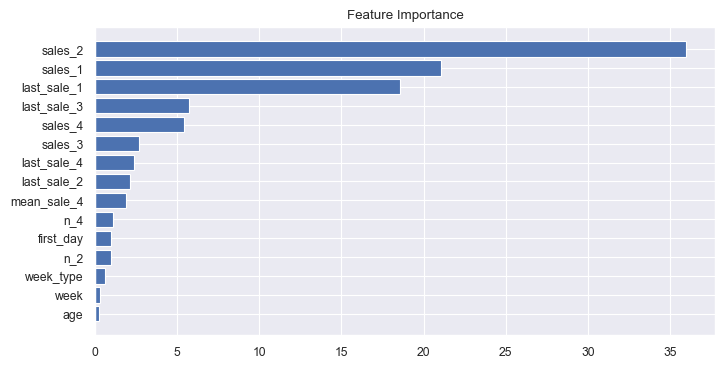

In [17]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.title('Feature Importance')

In [18]:
model_prod, _ = train_model(week_sales, T=7, vatidation=False, iterations=1500)